# Applied Machine Learning 
## Regression Model Evaluation on Sydney housing dataset
## Yunjun Xia

#### Data Source: https://www.kaggle.com/shree1992/housedata
### Part 1: Data Description

In [1]:
import pandas as pd
import numpy as np

In [2]:
house = pd.read_csv('data.csv')
house = house.drop(columns = 'date')

In [3]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 17 columns):
price            4600 non-null float64
bedrooms         4600 non-null float64
bathrooms        4600 non-null float64
sqft_living      4600 non-null int64
sqft_lot         4600 non-null int64
floors           4600 non-null float64
waterfront       4600 non-null int64
view             4600 non-null int64
condition        4600 non-null int64
sqft_above       4600 non-null int64
sqft_basement    4600 non-null int64
yr_built         4600 non-null int64
yr_renovated     4600 non-null int64
street           4600 non-null object
city             4600 non-null object
statezip         4600 non-null object
country          4600 non-null object
dtypes: float64(4), int64(9), object(4)
memory usage: 611.1+ KB


By looking at the information of the house sales dataset, we can find that features of type "object" are categorical features while other features with type "float" or "int" are continuous features.
Categorical Features: street, city, statezip, country.
Continuous Features: price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated.

In [4]:
index = []
for i in range(len(list(house.price))):
    if (list(house.price)[i] == 0) or (list(house.price)[i] > 10000000):
        index.append(i)
df_house = house.drop(index)
df_house.shape

(4549, 17)

#### Note:
I drop the rows with sales price = 0 or sales price > 10^7.

### Part 2: Continuous Feature and Target Distribution

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

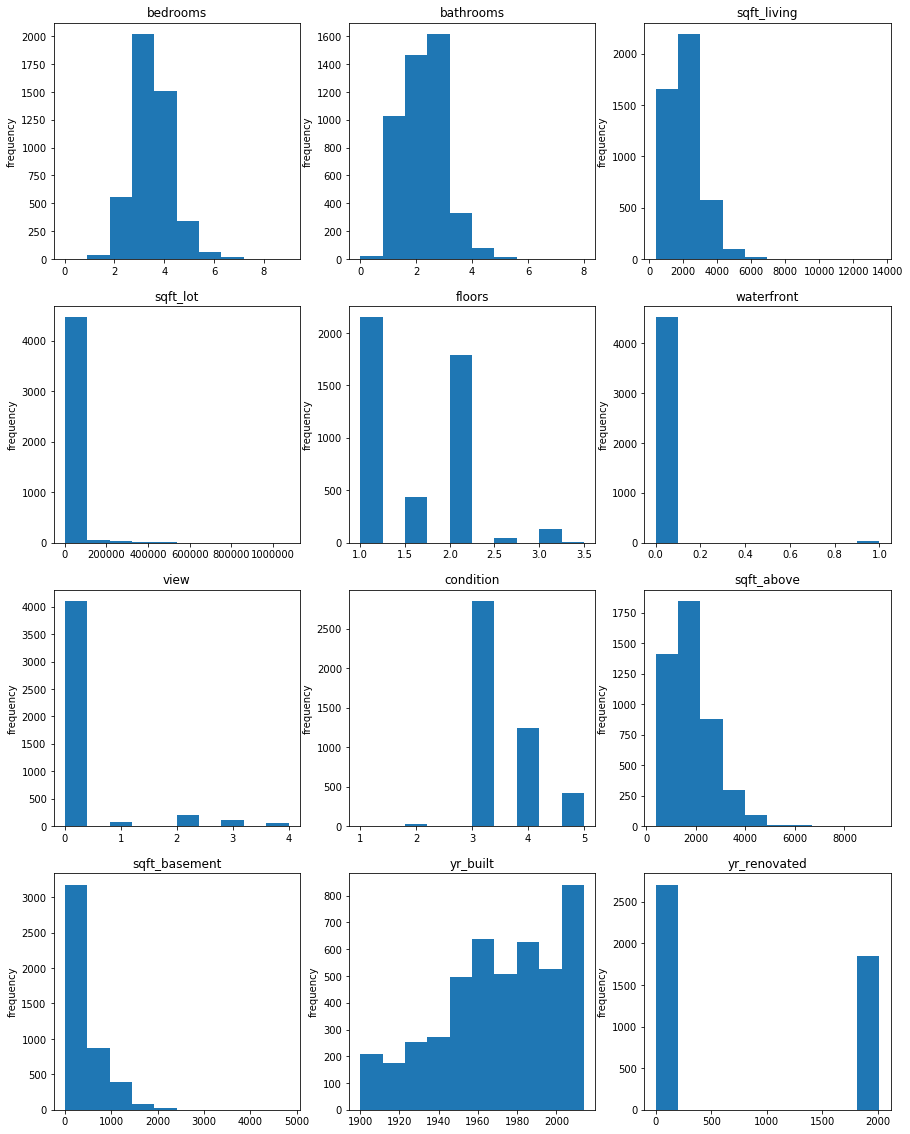

In [6]:
fig, ax = plt.subplots(4, 3, figsize = (15,20))
count = 1
for i in range(4):
    for j in range(3):
        ax[i,j].hist(df_house.iloc[:,count])
        ax[i,j].set_title(str(df_house.columns[count]))
        ax[i,j].set_ylabel('frequency')
        count = count + 1

Text(0, 0.5, 'frequency')

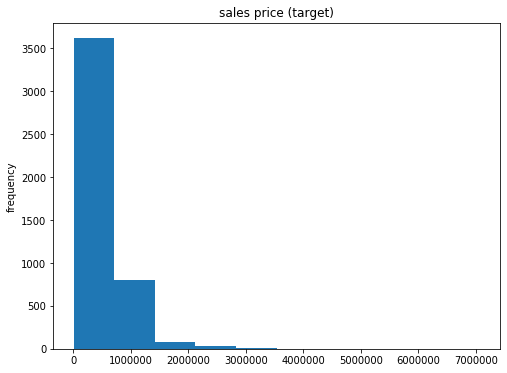

In [7]:
plt.figure(figsize = (8, 6))
plt.hist(df_house.price)
plt.title('sales price (target)')
plt.ylabel('frequency')

One problem is that the dataset has outliers(values being to large) for many of the continuous features(like sqft_lot, sqft_living, sqft_basement) and the target(price). Thus, it's hard to visualize the distribution of price and continuous features without treatment to outliers. In this case, we can drop outliers to make a better visualization.

Another problem is that for the "yr_renovated" feature and the "sqft_basement" feature, there are so many data with value = 0. This can be viewd as missing values. It's also hard to visualize the distribution of this feature without treatment to the 0 values.

Moreover, since there are only two unique values for "waterfront", maybe we can treat this feature as a categorical feature.

### Part 3: Dependency of target on each feature

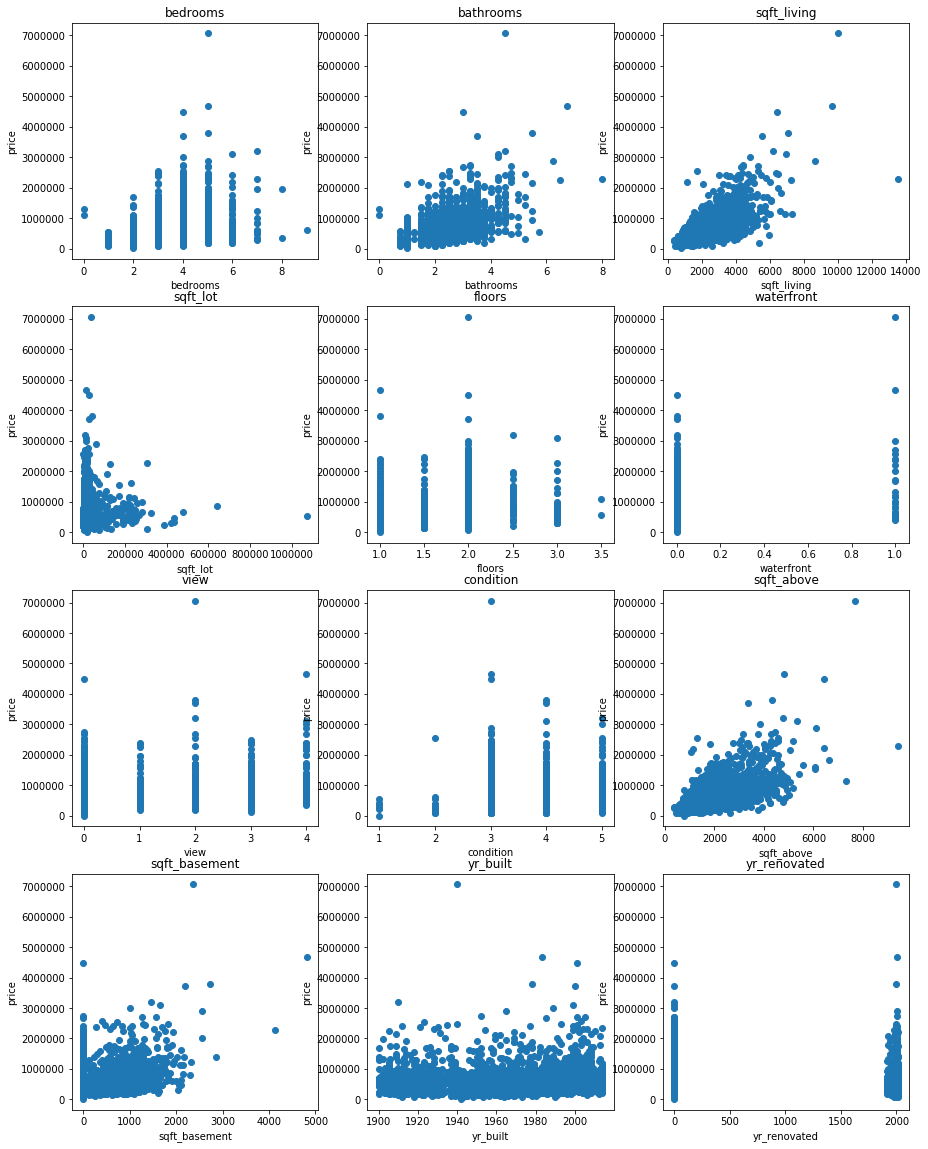

In [8]:
fig, ax = plt.subplots(4, 3, figsize = (15,20))
count = 1
for i in range(4):
    for j in range(3):
        ax[i,j].scatter(df_house.iloc[:,count], df_house.price)
        ax[i,j].set_title(str(df_house.columns[count]))
        ax[i,j].set_ylabel('price')
        ax[i,j].set_xlabel(str(df_house.columns[count]))
        count = count + 1

### Part 4: Preprocessing and Model Fit: OLS, Ridge, Lasso and ElasticNet

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [10]:
set(df_house.country)

{'USA'}

In [11]:
len(set(df_house.street))

4474

#### Note:
Since there is only one category "USA" for feature "country" and there are 4476 categories for feature "street", we drop these two columns for better fitting models. 
Also, let's declare the 0 values of "yr_renovated" and "sqft_basement" to be missing values.

In [12]:
df_house_clean = df_house.drop(columns = 'country')
df_house_clean = df_house_clean.drop(columns = 'street')
df_house_clean.yr_renovated = df_house_clean.yr_renovated.replace(0, np.nan)
df_house_clean.sqft_basement = df_house_clean.sqft_basement.replace(0, np.nan)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_house_clean.iloc[:,1:], 
                                                    df_house_clean.iloc[:,0], 
                                                    random_state = 1)

categorical = df_house_clean.iloc[:,1:].dtypes == 'object'

conti_pre = make_pipeline(SimpleImputer(strategy = 'median'))
conti_pre_scaled = make_pipeline(SimpleImputer(strategy = 'median'), StandardScaler())

cat_pre = make_pipeline(SimpleImputer(strategy = 'constant', fill_value = 'NA'), 
                        OneHotEncoder(handle_unknown='ignore'))

preprocess = make_column_transformer((conti_pre, ~categorical),
                                     (cat_pre, categorical))

preprocess_scaled = make_column_transformer((conti_pre_scaled, ~categorical),
                                            (cat_pre, categorical))

In [14]:
# Linear Regression
model_lr = make_pipeline(preprocess, LinearRegression())
model_lr_scaled = make_pipeline(preprocess_scaled, LinearRegression())

scores_lr = cross_val_score(model_lr, X_train, y_train)
scores_lr_scaled = cross_val_score(model_lr_scaled, X_train, y_train)

# Ridge
model_r = make_pipeline(preprocess, Ridge())
model_r_scaled = make_pipeline(preprocess_scaled, Ridge())

scores_r = cross_val_score(model_r, X_train, y_train)
scores_r_scaled = cross_val_score(model_r_scaled, X_train, y_train)

# Lasso
model_l = make_pipeline(preprocess, Lasso())
model_l_scaled = make_pipeline(preprocess_scaled, Lasso())

scores_l = cross_val_score(model_l, X_train, y_train)
scores_l_scaled = cross_val_score(model_l_scaled, X_train, y_train)

# ElasticNet
model_e = make_pipeline(preprocess, ElasticNet())
model_e_scaled = make_pipeline(preprocess_scaled, ElasticNet())

scores_e = cross_val_score(model_e, X_train, y_train)
scores_e_scaled = cross_val_score(model_e_scaled, X_train, y_train)

In [15]:
print(f'The 5-fold cv mean score of linear regression is: {np.mean(scores_lr)}')
print(f'The 5-fold cv mean score of linear regression with scaling is: {np.mean(scores_lr_scaled)}\n')

print(f'The 5-fold cv mean score of ridge is: {np.mean(scores_r)}')
print(f'The 5-fold cv mean score of ridge with scaling is: {np.mean(scores_r_scaled)}\n')

print(f'The 5-fold cv mean score of lasso is: {np.mean(scores_l)}')
print(f'The 5-fold cv mean score of lasso with scaling is: {np.mean(scores_l_scaled)}\n')

print(f'The 5-fold cv mean score of elastic net is: {np.mean(scores_e)}')
print(f'The 5-fold cv mean score of elastic net with scaling is: {np.mean(scores_e_scaled)}\n')

The 5-fold cv mean score of linear regression is: 0.7555894947476223
The 5-fold cv mean score of linear regression with scaling is: 0.7554271073053143

The 5-fold cv mean score of ridge is: 0.5388338881740073
The 5-fold cv mean score of ridge with scaling is: 0.7567782330762535

The 5-fold cv mean score of lasso is: 0.7554803973209105
The 5-fold cv mean score of lasso with scaling is: 0.7554798334915229

The 5-fold cv mean score of elastic net is: 0.593946339788286
The 5-fold cv mean score of elastic net with scaling is: 0.5809007178203834



#### Observation:
For ridge regression model, scaling helps to increase the mean cv score, but for other three models, scaling does not seem to much improve the results.

### Part 5: Parameter Tuning

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# Ridge
param_grid_r = {'ridge__alpha': np.logspace(-3, 4, 8)}
grid_r = GridSearchCV(model_r_scaled, param_grid_r, return_train_score = True)
grid_r.fit(X_train, y_train)

# Lasso
param_grid_l = {'lasso__alpha': np.logspace(-3, 4, 8)}
grid_l = GridSearchCV(model_l_scaled, param_grid_l, return_train_score = True)
grid_l.fit(X_train, y_train)

# ElasticNet
param_grid_e = {'elasticnet__alpha': np.logspace(-3, 4, 8), 
                'elasticnet__l1_ratio': [0.01, .1, .5, .8, .9, .95, .98, 1]}
grid_e = GridSearchCV(model_e_scaled, param_grid_e, return_train_score = True)
grid_e.fit(X_train, y_train)

print(f'Best parameter of ridge is: {grid_r.best_params_}')
print(f'Best mean cv score of ridge is: {grid_r.best_score_}')

print(f'Best parameter of lasso is: {grid_l.best_params_}')
print(f'Best mean cv score of lasso is: {grid_l.best_score_}')

print(f'Best parameter of elastic net is: {grid_e.best_params_}')
print(f'Best mean cv score of elastic net is: {grid_e.best_score_}')

Best parameter of ridge is: {'ridge__alpha': 1.0}
Best mean cv score of ridge is: 0.7567782330762535
Best parameter of lasso is: {'lasso__alpha': 100.0}
Best mean cv score of lasso is: 0.7557251406146536
Best parameter of elastic net is: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
Best mean cv score of elastic net is: 0.7576859367405582


#### Observation:
By using grid search, the mean cv score of elastic net model improves, but for the other two models, grid search does not seem to much improve the results.

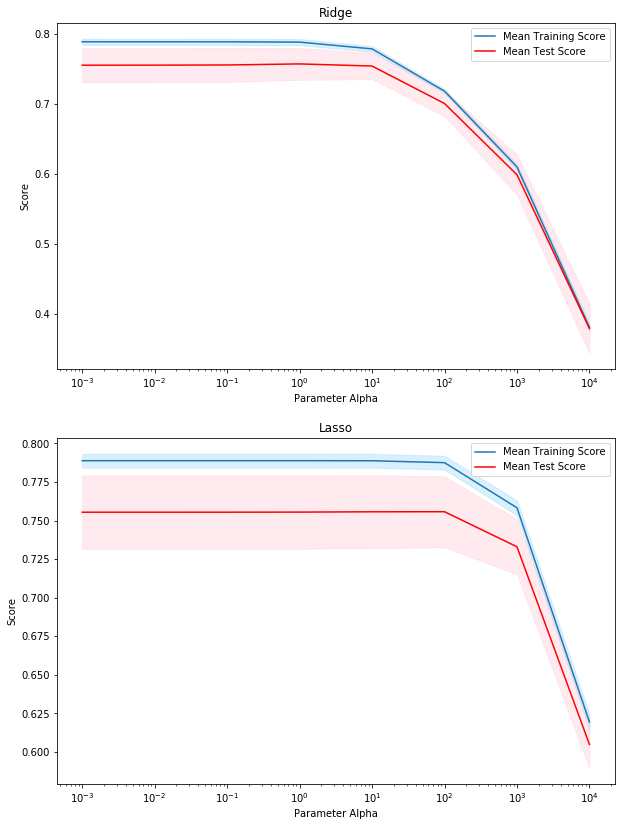

In [18]:
# Visualization
fig, ax = plt.subplots(2, 1, figsize = (10, 14))
# Ridge
ax[0].plot(np.logspace(-3,4,8), 
           grid_r.cv_results_['mean_train_score'],
           label = 'Mean Training Score')
ax[0].fill_between(np.logspace(-3,4,8),
                   grid_r.cv_results_['mean_train_score'] - grid_r.cv_results_['std_train_score'],
                   grid_r.cv_results_['mean_train_score'] + grid_r.cv_results_['std_train_score'],
                   color = 'lightskyblue', alpha = 0.3)
ax[0].plot(np.logspace(-3,4,8), 
           grid_r.cv_results_['mean_test_score'],
           color = 'red', label = 'Mean Test Score')
ax[0].fill_between(np.logspace(-3,4,8),
                   grid_r.cv_results_['mean_test_score'] - grid_r.cv_results_['std_test_score'],
                   grid_r.cv_results_['mean_test_score'] + grid_r.cv_results_['std_test_score'],
                   color = 'pink', alpha = 0.3)
ax[0].set_xscale('log')
ax[0].set_xlabel('Parameter Alpha')
ax[0].set_ylabel('Score')
ax[0].set_title('Ridge')
ax[0].legend()

# Lasso
ax[1].plot(np.logspace(-3,4,8), 
           grid_l.cv_results_['mean_train_score'],
           label = 'Mean Training Score')
ax[1].fill_between(np.logspace(-3,4,8),
                   grid_l.cv_results_['mean_train_score'] - grid_l.cv_results_['std_train_score'],
                   grid_l.cv_results_['mean_train_score'] + grid_l.cv_results_['std_train_score'],
                   color = 'lightskyblue', alpha = 0.3)
ax[1].plot(np.logspace(-3,4,8), 
           grid_l.cv_results_['mean_test_score'],
           color = 'red', label = 'Mean Test Score')
ax[1].fill_between(np.logspace(-3,4,8),
                   grid_l.cv_results_['mean_test_score'] - grid_l.cv_results_['std_test_score'],
                   grid_l.cv_results_['mean_test_score'] + grid_l.cv_results_['std_test_score'],
                   color = 'pink', alpha = 0.3)
ax[1].set_xscale('log')
ax[1].set_xlabel('Parameter Alpha')
ax[1].set_ylabel('Score')
ax[1].set_title('Lasso')
ax[1].legend()

In [19]:
train_score_e = pd.pivot_table(pd.DataFrame(grid_e.cv_results_),
    values='mean_train_score', index='param_elasticnet__alpha', columns='param_elasticnet__l1_ratio')
test_score_e = pd.pivot_table(pd.DataFrame(grid_e.cv_results_),
    values='mean_test_score', index='param_elasticnet__alpha', columns='param_elasticnet__l1_ratio')

Text(0, 0.5, 'Mean Test Score')

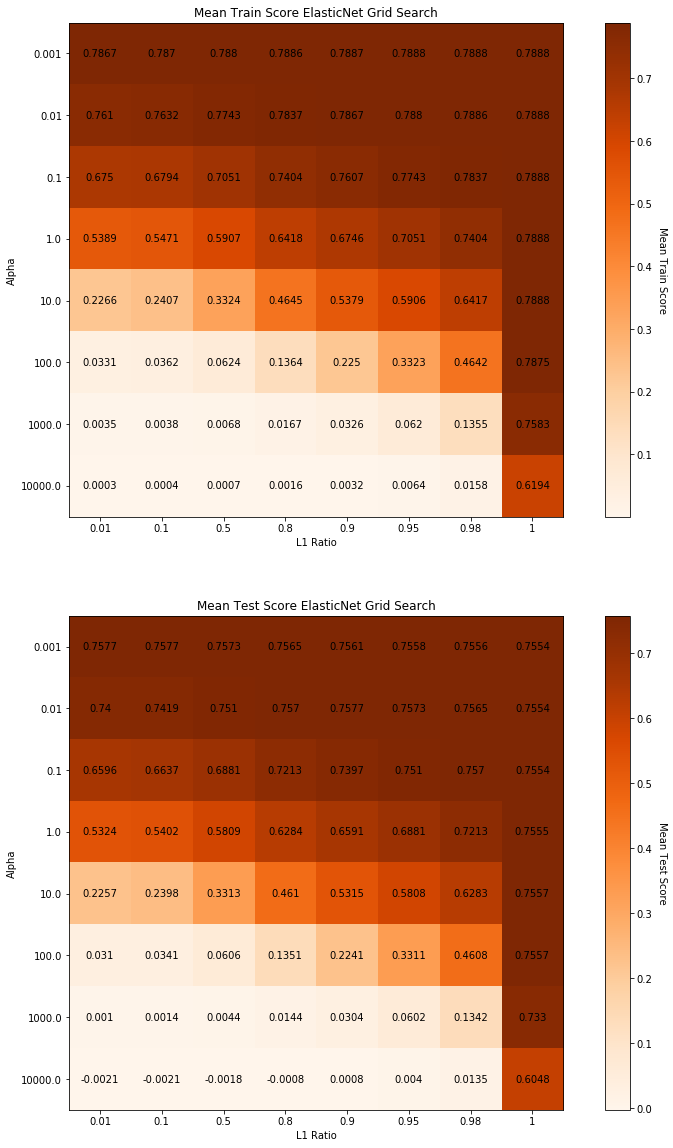

In [20]:
# ElasticNet
fig, ax = plt.subplots(2, 1, figsize = (15, 20))
im = ax[0].imshow(train_score_e, cmap = 'Oranges')
ax[0].set_xticks(np.arange(8))
ax[0].set_yticks(np.arange(8))
ax[0].set_xticklabels([0.01, .1, .5, .8, .9, .95, .98, 1])
ax[0].set_yticklabels(np.logspace(-3,4,8))

for i in range(8):
    for j in range(8):
        text = ax[0].text(j, i, round(train_score_e.iloc[i, j], 4),
                       ha='center', va='center')

ax[0].set_title('Mean Train Score ElasticNet Grid Search')
ax[0].set_xlabel('L1 Ratio')
ax[0].set_ylabel('Alpha')

cbar = ax[0].figure.colorbar(im, ax = ax[0])
cbar.ax.set_ylabel('Mean Train Score', rotation=-90, va="bottom")

im = ax[1].imshow(test_score_e, cmap = 'Oranges')
ax[1].set_xticks(np.arange(8))
ax[1].set_yticks(np.arange(8))
ax[1].set_xticklabels([0.01, .1, .5, .8, .9, .95, .98, 1])
ax[1].set_yticklabels(np.logspace(-3,4,8))

for i in range(8):
    for j in range(8):
        text = ax[1].text(j, i, round(test_score_e.iloc[i, j], 4),
                       ha='center', va='center')

ax[1].set_title('Mean Test Score ElasticNet Grid Search')
ax[1].set_xlabel('L1 Ratio')
ax[1].set_ylabel('Alpha')

cbar = ax[1].figure.colorbar(im, ax = ax[1])
cbar.ax.set_ylabel('Mean Test Score', rotation=-90, va="bottom")

### Part 6: 20 Most Important Coefficients

In [21]:
ohe = OneHotEncoder()
ohe.fit(X_train[X_train.select_dtypes(include=['object']).columns], y_train)
all_columns = np.hstack([X_train.select_dtypes(include=['float64','int64']).columns, ohe.get_feature_names()])

# Ridge
index_r = list(np.argsort(np.abs(grid_r.best_estimator_['ridge'].coef_)))[-20:]
estimate_r = [list(grid_r.best_estimator_['ridge'].coef_)[i] for i in index_r]

# Lasso
index_l = list(np.argsort(np.abs(grid_l.best_estimator_['lasso'].coef_)))[-20:]
estimate_l = [list(grid_l.best_estimator_['lasso'].coef_)[i] for i in index_l]

# ElasticNet
index_e = list(np.argsort(np.abs(grid_e.best_estimator_['elasticnet'].coef_)))[-20:]
estimate_e = [list(grid_e.best_estimator_['elasticnet'].coef_)[i] for i in index_e]

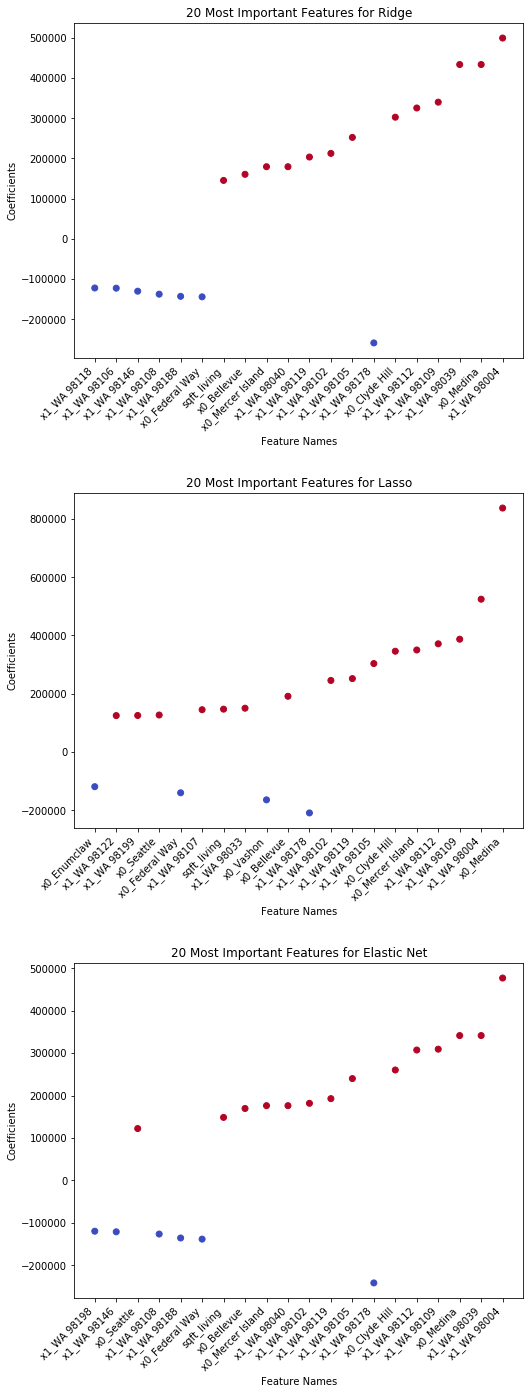

In [22]:
# Visualization
fig, ax = plt.subplots(3, 1, figsize = (8, 20))
ax[0].scatter(all_columns[index_r], estimate_r, c = np.sign(estimate_r), cmap = 'coolwarm')
ax[0].set_ylabel('Coefficients')
ax[0].set_xlabel('Feature Names')
ax[0].set_title('20 Most Important Features for Ridge')
ax[0].set_xticklabels(all_columns[index_r], rotation=45, horizontalalignment='right')

ax[1].scatter(all_columns[index_l], estimate_l, c = np.sign(estimate_l), cmap = 'coolwarm')
ax[1].set_ylabel('Coefficients')
ax[1].set_xlabel('Feature Names')
ax[1].set_title('20 Most Important Features for Lasso')
ax[1].set_xticklabels(all_columns[index_l], rotation=45, horizontalalignment='right')

ax[2].scatter(all_columns[index_e], estimate_e, c = np.sign(estimate_e), cmap = 'coolwarm')
ax[2].set_ylabel('Coefficients')
ax[2].set_xlabel('Feature Names')
ax[2].set_title('20 Most Important Features for Elastic Net')
ax[2].set_xticklabels(all_columns[index_e], rotation=45, horizontalalignment='right')

fig.tight_layout(pad=3.0)

#### Observation:
The three models do not agree on the most important 20 features.